In [208]:
import torch
import torch.nn as nn
from torchvision.transforms import GaussianBlur
import numpy as np
import torchvision as T
import tqdm
import matplotlib.pyplot as plt
from scipy import signal
from torchsummary import summary

In [209]:
#create a gaussian filter

def create_cloud_image(meanx,meany,amplitude):
  #create filter
  img = torch.tensor(np.zeros((1,49,49)))
  img[:,25,25]=10
  img = GaussianBlur(kernel_size=(49, 49), sigma=amplitude)(img)
  #displace towards mean
  for i in range(49):
    for j in range(49):
      if i+meanx>0 and i+meanx<49 and j+meany>0 and j+meany<49: 
        img[:,i,j] = img[:,i+meanx,j+meany]
      else:
        img[:,i,j] = 0
  return img[:,:48,:48]

In [207]:
#generate gaussian images
means = list(zip(np.random.randint(0,30,1000),np.random.randint(0,30,1000)))

X1 = [create_cloud_image(mean[0],mean[1],10) for mean in means]
y1 = [0]*len(X1)
X2 = [create_cloud_image(mean[0],mean[1],5) for mean in means]
y2 = [1]*len(X1)

#concatenate
X = torch.vstack((torch.stack(X1),torch.stack(X2)))
y = torch.hstack((torch.tensor(y1),torch.tensor(y2)))
y
#shuffle
idx = list(range(len(X)))
np.random.shuffle(idx)
Xs=X[idx].float() * 100
ys=y[idx].long() * 100    #mult by 100 to have big enough values for MSELoss

In [210]:
#shuffle
idx = list(range(len(X)))
np.random.shuffle(idx)
Xs=X[idx].float()
ys=Xs.reshape(len(Xs),48,48)

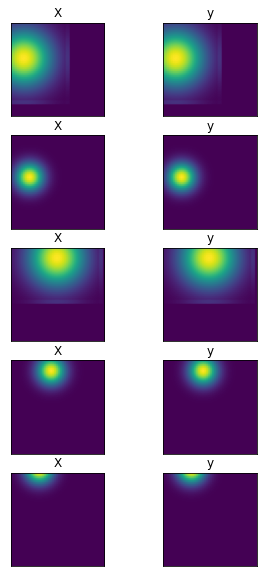

In [211]:
#visualize
plt.figure(figsize=(5,10))
for i in range(1,11,2):
  plt.subplot(5,2,i)
  plt.title("X")
  plt.gca().get_xaxis().set_visible(False)
  plt.gca().get_yaxis().set_visible(False)
  plt.imshow(Xs.detach()[i][0])
  plt.subplot(5,2,i+1)
  plt.title("y")
  plt.gca().get_xaxis().set_visible(False)
  plt.gca().get_yaxis().set_visible(False)
  plt.imshow(ys.detach()[i].reshape((48,48)))

In [212]:
class Model(nn.Module):
  def __init__(self):
    super().__init__()
    self.conv1 =  nn.Conv2d(1,5,3,(2,2))
    self.conv2 =  nn.Conv2d(5,10,3,(2,2))
    #self.fl = nn.Flatten()
    #self.lin = nn.Linear(9*9*10,16)
    #self.ufl = nn.Unflatten(1,(1,4,4))
    self.deconv = nn.ConvTranspose2d(10,5,4,2)
    self.deconv2 = nn.ConvTranspose2d(5,1,2,2)

  def forward(self,x):
    x = self.conv1(x)
    x = nn.functional.relu(x)
    x = self.conv2(x)
    x = nn.functional.relu(x)


    #x = self.fl(x)
    #x = self.lin(x)
    #code = x
    #x = self.ufl(x)
    x = self.deconv(x)
    x = nn.functional.relu(x)
    x = self.deconv2(x)
    #x = torch.sigmoid(x)
    #x = x.reshape((len(x),48,48))
    return x

In [213]:
model = Model()
summary(model,(1,48,48))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1            [-1, 5, 23, 23]              50
            Conv2d-2           [-1, 10, 11, 11]             460
   ConvTranspose2d-3            [-1, 5, 24, 24]             805
   ConvTranspose2d-4            [-1, 1, 48, 48]              21
Total params: 1,336
Trainable params: 1,336
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.01
Forward/backward pass size (MB): 0.07
Params size (MB): 0.01
Estimated Total Size (MB): 0.08
----------------------------------------------------------------


In [214]:
def create_the_model():
  model = Model()
  loss = nn.MSELoss()
  opt = torch.optim.Adam(model.parameters(),lr=0.001)
  return model,loss,opt

In [215]:
def train_the_model(X_train, y_train, mb_size, nb_epochs):
  trainacc = []
  testacc = []
  
  minibatch_X = [X_train[k:k+mb_size] for k in range(0,len(X_train), mb_size)]
  minibatch_y = [y_train[k:k+mb_size] for k in range(0,len(y_train), mb_size)]
  for i in tqdm.trange(nb_epochs):
    for (X_b,y_b) in zip(minibatch_X,minibatch_y):
      pred = model(X_b)
      l = loss(pred,X_b)

      opt.zero_grad()
      l.backward()
      opt.step()

    pred = model(X_train[:100])
    l = loss(pred,X_train[:100])
    trainacc.append(l.item())


  return trainacc

In [216]:
model,loss,opt = create_the_model()
trainacc= train_the_model(Xs,ys,32,16)

100%|██████████| 16/16 [00:10<00:00,  1.48it/s]


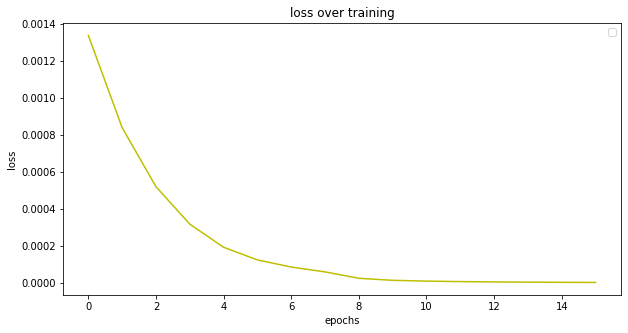

In [217]:
plt.figure(figsize=(10,5))
plt.title("loss over training")
plt.plot(trainacc,"y")
plt.xlabel("epochs")
plt.ylabel("loss")
plt.legend()

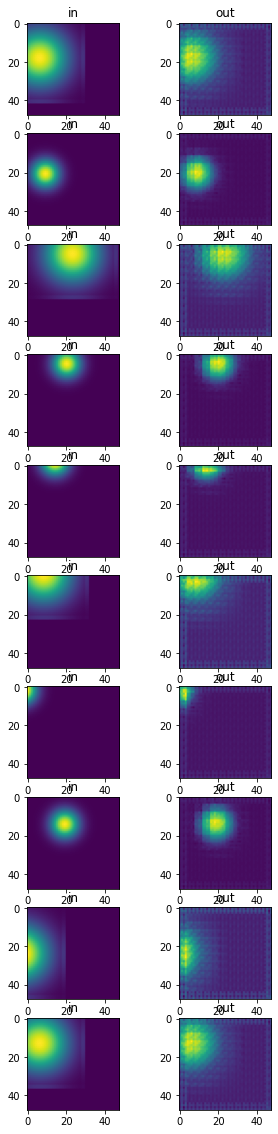

In [218]:
res = model(Xs[:20])
plt.figure(figsize=(5,20))
for i in range(1,20,2):
  plt.subplot(10,2,i)
  plt.title("in")
  plt.imshow(Xs[i][0].detach().numpy())
  plt.subplot(10,2,i+1)
  plt.title("out")
  plt.imshow(res[i][0].detach().numpy())

In [219]:
res[0]-Xs[0]

tensor([[[-7.2382e-03, -1.0205e-02, -1.4697e-02,  ...,  2.8722e-03,
           3.8745e-04,  3.4122e-03],
         [-1.7821e-03, -9.0293e-03, -1.4577e-02,  ...,  3.1863e-03,
           1.6946e-04,  3.2924e-03],
         [-1.4292e-03, -3.4316e-03, -2.5162e-03,  ...,  2.5760e-03,
          -1.7815e-03,  2.4747e-03],
         ...,
         [-6.4516e-04,  3.3047e-03,  1.2473e-03,  ...,  1.9019e-03,
           6.9108e-04,  1.7091e-03],
         [-8.5916e-04,  2.0362e-03, -2.2872e-03,  ...,  2.9838e-03,
           1.3250e-03,  2.9881e-03],
         [-3.2946e-05,  3.5300e-03, -9.3362e-04,  ...,  2.2150e-03,
           2.0646e-03,  2.8520e-03]]], grad_fn=<SubBackward0>)

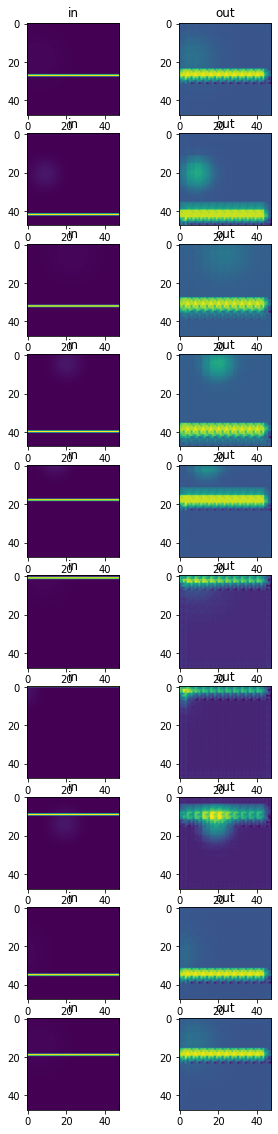

In [220]:
#occlude images
res = Xs[:20]
for i in range(len(res)):
  x = np.random.randint(47)
  for j in range(48):
    res[i,:,x,j]=1

resres = model(res)
plt.figure(figsize=(5,20))
for i in range(1,20,2):
  plt.subplot(10,2,i)
  plt.title("in")
  plt.imshow(res[i][0].detach().numpy())
  plt.subplot(10,2,i+1)
  plt.title("out")
  plt.imshow(resres[i][0].detach().numpy())